In [1]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import truvari
import joblib
import glob
import os
from IPython.display import display, Markdown

SZBINTY = pd.CategoricalDtype(truvari.SZBINS[1:], ordered=True)
ref_order = ["hg19", "grch38", "chm13"]
sb.set()

In [2]:
metadata = pd.read_csv("../lra_sr_metadata.txt", sep="\t")
metadata = metadata.set_index("Individual")

In [3]:
data = joblib.load("../stats/single_sample_stats.jl")
weird_sample = data["sample"] == "NA18939"
data = data[~weird_sample & ~(data["merge"].str.startswith("removed"))]

In [4]:
def plot_sv_counts(m_data):
    """
    Creates a view of the data by reference/sample/project and by svtype with the counts
    Creates a plot, also
    Returns the data view overall and the dataview by svtype
    """
    view = []
    view_bytype = []
    for idx, subdat in m_data.groupby(["reference", "sample", "project"]):
        view.append([idx[0], idx[1], metadata.loc[idx[1]]["Superpopulation code"], len(subdat)])
        subdat["count"] = 1
        tygrp = subdat.groupby(["svtype"]).sum()["count"]
        view_bytype.append([idx[0], idx[1], metadata.loc[idx[1]]["Superpopulation code"], "DEL", tygrp.loc["DEL"]])
        view_bytype.append([idx[0], idx[1], metadata.loc[idx[1]]["Superpopulation code"], "INS", tygrp.loc["INS"]])

    view = pd.DataFrame(view, columns=["reference", "sample", "Superpopulation", "svcount"])
    view_bytype = pd.DataFrame(view_bytype, columns=["reference", "sample", "Superpopulation", "svtype", "svcount"])
    p = sb.catplot(data=view, x="reference", y="svcount", hue="Superpopulation", order=ref_order)
    p.set(title="SV Counts per-sample by reference", xlabel="Reference", ylabel="Count")
    plt.show()
    p = sb.catplot(data=view_bytype, x="svtype", y="svcount", hue="Superpopulation", col="reference", col_order=ref_order)
    #p.set(title="SV Counts per-sample by reference/SVTYPE", xlabel="Reference", ylabel="Count")
    p.fig.subplots_adjust(top=0.9) 
    hide = p.fig.suptitle('SV Counts per-sample by reference/SVTYPE')
    plt.show()
    
    with pd.option_context('display.float_format', '{:,.0f}'.format):
        display(view.groupby(["reference"]).describe())
    
    with pd.option_context('display.float_format', '{:,.0f}'.format):
        display(view_bytype.groupby(["reference", "svtype"]).describe())

    return view, view_bytype
    
def plot_svsize_counts(m_data):
    """
    Creates a view of the data by reference/sample/project and by sizebin with the counts
    Creates a plot, also
    Returns the data view overall and the dataview by svtype
    """
    view = []
    view_bytype = []
    for idx, subdat in m_data.groupby(["reference", "sample", "project"]):
        for size, subdat2 in subdat.groupby("szbin"):
            view.append([idx[0], idx[1], metadata.loc[idx[1]]["Superpopulation code"], size, len(subdat2)])
        for idx2, subdat2 in subdat.groupby(["svtype", "szbin"]):
            svtype, szbin = idx2        
            view_bytype.append([idx[0], idx[1], metadata.loc[idx[1]]["Superpopulation code"], svtype, szbin, len(subdat2)])

    view = pd.DataFrame(view, columns=["reference", "sample", "Superpopulation", "szbin", "svcount"])
    view_bytype = pd.DataFrame(view_bytype, columns=["reference", "sample", "Superpopulation", "svtype", "szbin", "svcount"])
    p = sb.barplot(data=view, x="szbin", y="svcount", order=truvari.SZBINS[1:], hue="reference", hue_order=ref_order)
    p.set(title=f"SV count by SV size")
    plt.xticks(rotation=45, ha="right")
    plt.show()
    p = sb.catplot(data=view_bytype, kind="bar", x="szbin", y="svcount", col="reference", hue="svtype", col_order=ref_order)
    [plt.setp(ax.get_xticklabels(), rotation=45, ha="right") for ax in p.axes.flat]
    p.fig.subplots_adjust(top=0.9) 
    hide = p.fig.suptitle('SV count by SV size/type per-reference')
    plt.show()
    view["szbin"] = view["szbin"].astype(SZBINTY)
    view_bytype["szbin"] = view_bytype["szbin"].astype(SZBINTY)
    
    with pd.option_context('display.float_format', '{:,.0f}'.format):
        display(view.groupby(["reference", "szbin"]).describe())

    with pd.option_context('display.float_format', '{:,.0f}'.format):
        display(view_bytype.groupby(["reference", "svtype", "szbin"]).describe())
    return view, view_bytype

def plot_hethom_stats(m_data):
    """
    Creates a view of the data by reference/sample/project and summarizes the GT counts and ratios
    Creates a plot, also
    Return the data view
    """
    view = []
    for idx, subdat in m_data.groupby(["reference", "sample", "project"]):
        subdat["count"] = 1
        gtgrp = subdat.groupby(["GT"]).sum()["count"]    
        view.append([idx[0], idx[1], metadata.loc[idx[1]]["Superpopulation code"], "TOT", gtgrp.loc["HET"], gtgrp.loc["HOM"]])
        for idx2, subdat2 in subdat.groupby(["svtype"]):
            if idx2 not in ["DEL", "INS"]: continue
            gtgrp = subdat2.groupby(["GT"]).sum()["count"]   
            view.append([idx[0], idx[1], metadata.loc[idx[1]]["Superpopulation code"], idx2, gtgrp.loc["HET"], gtgrp.loc["HOM"]])
    view = pd.DataFrame(view, columns=["reference", "sample", "Superpopulation", "svtype", "HET", "HOM"])
    view["Ratio"] = view["HET"] / view["HOM"]

    p = sb.catplot(data=view[view["svtype"] == "TOT"], x="reference", y="Ratio", hue="Superpopulation", order=ref_order)
    p.set(title="Het/Hom ratio per-sample by reference", xlabel="Reference", ylabel="Het/Hom Ratio")
    plt.show()
    
    with pd.option_context('display.float_format', '{:.2f}'.format):
        display(view.groupby(["reference", "svtype"])["Ratio"].describe())
    return view


First, let's look at just the generic "strict" strategy's numbers

# Strict Merging - Per-Sample Stats

## SVCounts per-sample

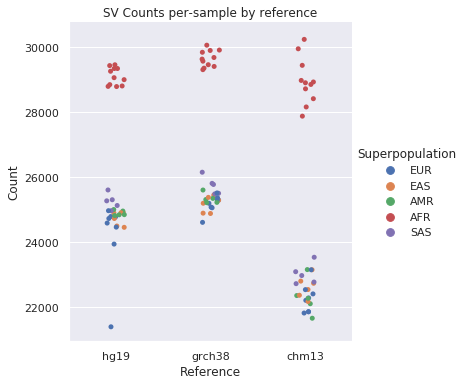

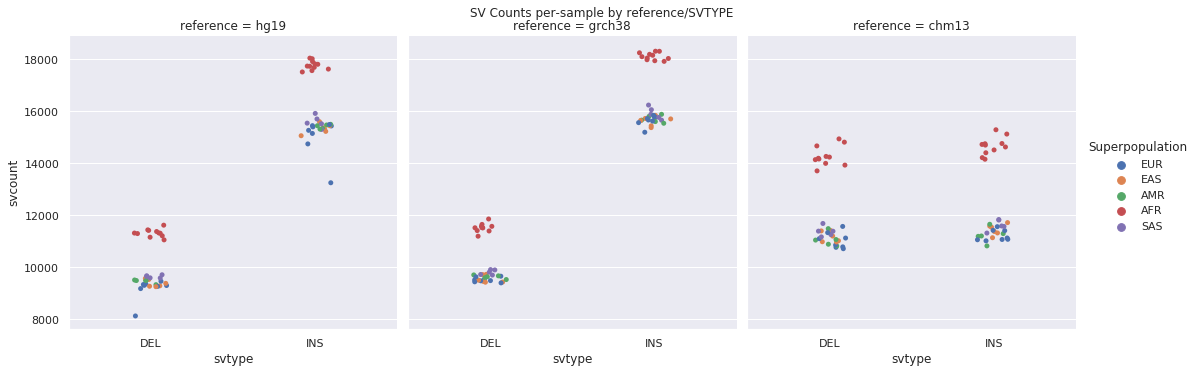

svcount                                                
            count   mean   std    min    25%    50%    75%    max
reference                                                        
chm13          35 24,537 3,080 21,652 22,313 22,794 28,282 30,235
grch38         35 26,682 2,056 24,603 25,250 25,479 29,376 30,056
hg19           35 26,077 2,176 21,388 24,774 24,961 28,794 29,453

svcount                                                
                   count   mean   std    min    25%    50%    75%    max
reference svtype                                                        
chm13     DEL         35 12,133 1,507 10,719 11,038 11,391 13,968 14,942
          INS         35 12,404 1,580 10,827 11,254 11,575 14,314 15,293
grch38    DEL         35 10,215   914  9,405  9,527  9,711 11,408 11,862
          INS         35 16,467 1,149 15,198 15,662 15,808 17,967 18,314
hg19      DEL         35  9,996   950  8,133  9,339  9,537 11,188 11,624
          INS         35 16,082 1,234 13,255 15,332 15,495 17,598 18,048

## SVCounts by SZBIN per-sample

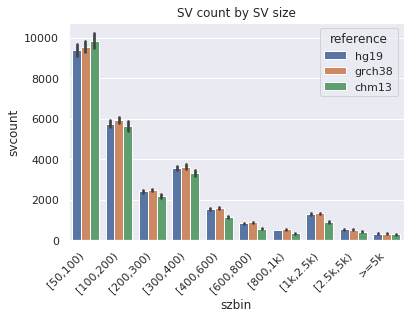

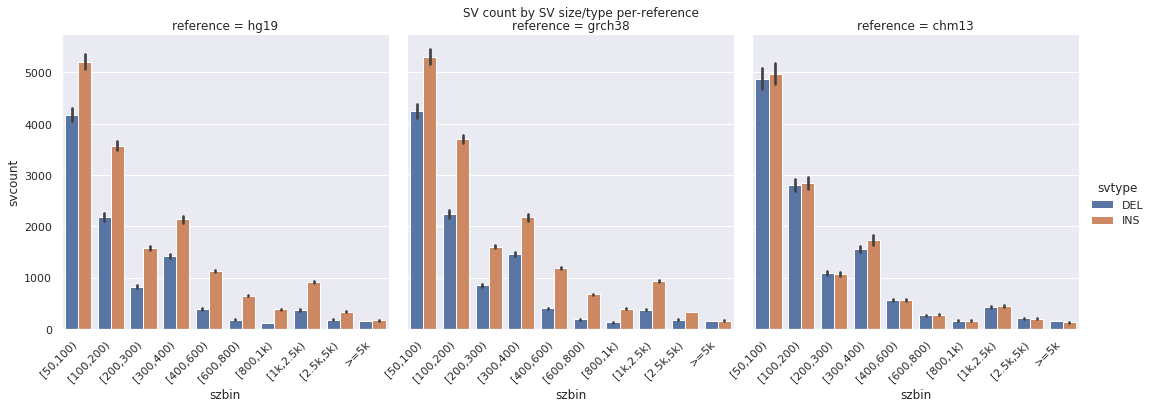

svcount                                            
                      count  mean   std   min   25%   50%    75%    max
reference szbin                                                        
chm13     [50,100)       35 9,852 1,215 8,672 8,993 9,166 11,362 12,041
          [100,200)      35 5,648   725 4,980 5,104 5,241  6,524  6,913
          [200,300)      35 2,166   260 1,908 1,974 2,036  2,434  2,736
          [300,400)      35 3,292   467 2,855 2,941 3,036  3,828  4,293
          [400,600)      35 1,139   132   969 1,042 1,092  1,277  1,398
          [600,800)      35   543    73   448   491   517    598    723
          [800,1k)       35   325    43   263   294   312    359    431
          [1k,2.5k)      35   883   113   740   798   829  1,016  1,088
          [2.5k,5k)      35   408    51   336   370   391    460    500
          >=5k           35   280    38   230   254   266    316    343
grch38    [50,100)       35 9,550   827 8,783 8,960 9,084 10,652 10,941
          [100,200)      35 5,934   460 5,444 5,600 5,684  6,544  6,699
          [200,300)      35 2,452   173 2,232 2,343 2,367  2,639  2,760
          [300,400)      35 3,628   316 3,337 3,399 3,448  4,023  4,194
          [400,600)      35 1,584    89 1,467 1,523 1,559  1,685  1,761
          [600,800)      35   869    54   768   832   855    913    965
          [800,1k)       35   522    33   469   495   521    542    588
          [1k,2.5k)      35 1,312    80 1,212 1,252 1,290  1,394  1,476
          [2.5k,5k)      35   513    42   445   485   503    537    606
          >=5k           35   317    26   268   300   314    336    362
hg19      [50,100)       35 9,392   870 7,587 8,837 8,976 10,520 10,794
          [100,200)      35 5,756   478 4,743 5,453 5,527  6,368  6,523
          [200,300)      35 2,405   188 2,007 2,288 2,337  2,607  2,716
          [300,400)      35 3,554   328 2,917 3,321 3,394  3,963  4,136
          [400,600)      35 1,523    99 1,264 1,468 1,496  1,622  1,715
          [600,800)      35   825    57   720   786   804    878    929
          [800,1k)       35   506    34   429   482   510    528    568
          [1k,2.5k)      35 1,281    92 1,063 1,213 1,263  1,364  1,450
          [2.5k,5k)      35   518    44   421   488   510    544    609
          >=5k           35   318    29   237   302   313    340    361

svcount                                        
                             count  mean std   min   25%   50%   75%   max
reference svtype szbin                                                    
chm13     DEL    [50,100)       35 4,877 600 4,295 4,450 4,582 5,604 5,955
                 [100,200)      35 2,802 368 2,396 2,535 2,625 3,266 3,451
                 [200,300)      35 1,096 127   957 1,003 1,024 1,227 1,356
                 [300,400)      35 1,565 187 1,374 1,426 1,476 1,756 1,972
                 [400,600)      35   567  73   486   514   536   626   725
                 [600,800)      35   264  38   200   240   258   290   351
                 [800,1k)       35   164  21   131   150   158   178   216
                 [1k,2.5k)      35   436  67   355   385   408   508   573
                 [2.5k,5k)      35   209  28   181   187   197   238   268
                 >=5k           35   153  21   118   140   145   176   193
          INS    [50,100)       35 4,976 619 4,377 4,520 4,670 5,744 6,096
                 [100,200)      35 2,846 360 2,486 2,587 2,666 3,274 3,462
                 [200,300)      35 1,070 137   915   963 1,021 1,216 1,380
                 [300,400)      35 1,727 281 1,481 1,516 1,570 2,053 2,321
                 [400,600)      35   572  66   460   526   558   622   699
                 [600,800)      35   279  40   215   253   267   306   372
                 [800,1k)       35   162  24   126   142   158   183   215
                 [1k,2.5k)      35   447  49   372   416   429   496   542
                 [2.5k,5k)      35   199  25   153   176   196   218   253
                 >=5k           35   127  19    99   112   122   144   159
grch38    DEL    [50,100)       35 4,243 386 3,835 3,959 4,052 4,726 4,918
                 [100,200)      35 2,238 211 2,008 2,086 2,127 2,507 2,621
                 [200,300)      35   848  75   751   794   814   910 1,002
                 [300,400)      35 1,455 113 1,322 1,367 1,404 1,594 1,651
                 [400,600)      35   400  40   343   372   386   436   488
                 [600,800)      35   190  23   157   172   184   210   232
                 [800,1k)       35   127  11   111   120   124   134   149
                 [1k,2.5k)      35   377  43   328   340   362   420   467
                 [2.5k,5k)      35   181  25   149   164   171   198   237
                 >=5k           35   155  14   134   144   153   162   187
          INS    [50,100)       35 5,307 446 4,841 4,986 5,041 5,893 6,100
                 [100,200)      35 3,696 253 3,415 3,514 3,576 4,012 4,131
                 [200,300)      35 1,605 102 1,450 1,537 1,562 1,716 1,782
                 [300,400)      35 2,173 206 1,956 2,026 2,073 2,424 2,556
                 [400,600)      35 1,184  56 1,096 1,143 1,171 1,220 1,301
                 [600,800)      35   679  36   607   659   678   701   756
                 [800,1k)       35   394  24   349   378   396   410   439
                 [1k,2.5k)      35   935  42   872   906   928   955 1,040
                 [2.5k,5k)      35   331  22   286   317   331   346   386
                 >=5k           35   162  14   134   152   162   170   188
hg19      DEL    [50,100)       35 4,178 402 3,409 3,914 3,995 4,678 4,864
                 [100,200)      35 2,181 216 1,750 2,041 2,079 2,436 2,566
                 [200,300)      35   827  79   692   769   798   902   970
                 [300,400)      35 1,420 115 1,191 1,334 1,372 1,568 1,607
                 [400,600)      35   387  40   319   356   377   419   481
                 [600,800)      35   179  24   146   160   172   200   231
                 [800,1k)       35   121  11   100   112   121   128   145
                 [1k,2.5k)      35   366  48   276   332   352   412   455
                 [2.5k,5k)      35   184  25   138   167   175   206   235
                 >=5k           35   153  16   112   142   152   162   186
          INS    [50,100)       35 5,214 472 4,178 4

## SV HET/HOM Ratios

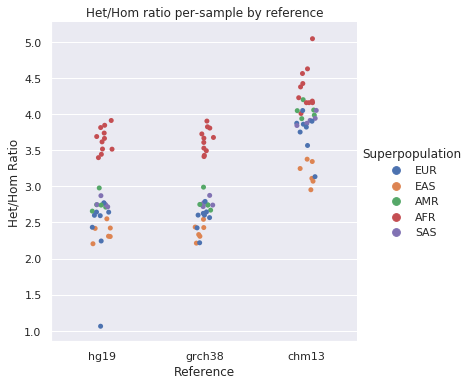

count  mean  std  min  25%  50%  75%  max
reference svtype                                           
chm13     DEL     35.00  3.56 0.42 2.64 3.42 3.60 3.80 4.57
          INS     35.00  4.30 0.53 3.28 4.18 4.32 4.59 5.58
          TOT     35.00  3.91 0.46 2.95 3.78 3.94 4.16 5.04
grch38    DEL     35.00  2.80 0.49 2.03 2.54 2.66 3.31 3.63
          INS     35.00  3.02 0.56 2.23 2.64 2.79 3.58 4.09
          TOT     35.00  2.93 0.53 2.21 2.58 2.74 3.46 3.90
hg19      DEL     35.00  2.77 0.57 1.08 2.47 2.66 3.31 3.65
          INS     35.00  2.96 0.65 1.05 2.64 2.80 3.57 4.09
          TOT     35.00  2.89 0.61 1.06 2.57 2.74 3.48 3.91

In [5]:
strict_data = data[(data["merge"] == "strict")]
display(Markdown("# Strict Merging - Per-Sample Stats"))
display(Markdown("## SVCounts per-sample"))
strict_sv_counts = plot_sv_counts(strict_data)
display(Markdown("## SVCounts by SZBIN per-sample"))
strict_sz_counts = plot_svsize_counts(strict_data)
display(Markdown("## SV HET/HOM Ratios"))
strict_gt_counts = plot_hethom_stats(strict_data)

Then, we'll look at a comparison of the strategies and what it means for the truth set SV counts by comparing with 'exact' and 'loose' merges

# Exact Merging - Per-Sample Stats

## SVCounts per-sample

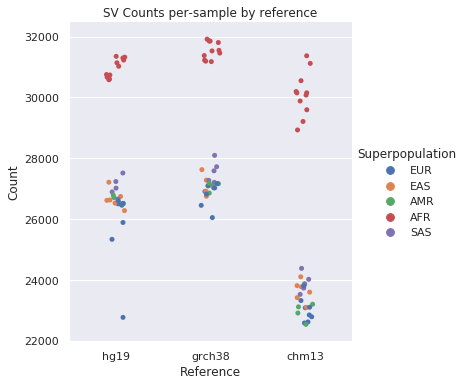

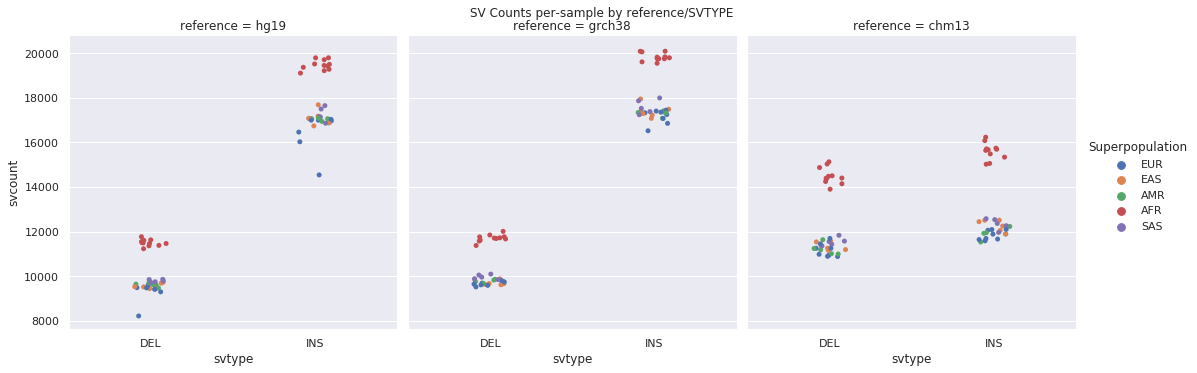

svcount                                                
            count   mean   std    min    25%    50%    75%    max
reference                                                        
chm13          35 25,491 3,227 22,533 23,102 23,798 29,402 31,370
grch38         35 28,502 2,120 26,046 27,058 27,206 31,210 31,917
hg19           35 27,875 2,259 22,763 26,518 26,741 30,636 31,352

svcount                                                
                   count   mean   std    min    25%    50%    75%    max
reference svtype                                                        
chm13     DEL         35 12,309 1,536 10,885 11,220 11,540 14,200 15,133
          INS         35 13,182 1,700 11,536 11,938 12,265 15,202 16,237
grch38    DEL         35 10,375   927  9,521  9,671  9,864 11,598 12,014
          INS         35 18,127 1,205 16,525 17,310 17,418 19,687 20,095
hg19      DEL         35 10,151   965  8,218  9,489  9,697 11,374 11,773
          INS         35 17,724 1,308 14,545 16,984 17,088 19,254 19,800

## SVCounts by SZBIN per-sample

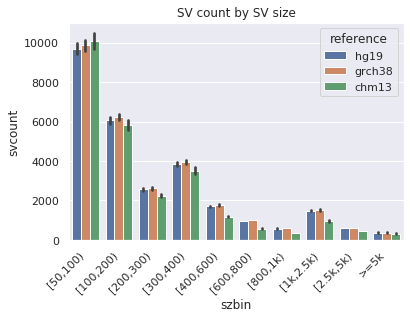

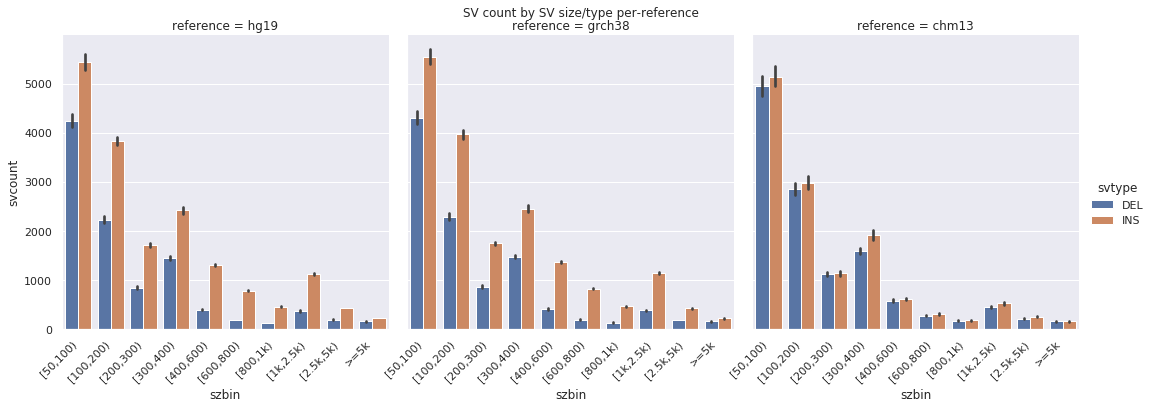

svcount                                             
                      count   mean   std   min   25%   50%    75%    max
reference szbin                                                         
chm13     [50,100)       35 10,088 1,251 8,908 9,199 9,394 11,651 12,323
          [100,200)      35  5,830   755 5,126 5,290 5,456  6,739  7,147
          [200,300)      35  2,246   271 1,962 2,062 2,110  2,526  2,820
          [300,400)      35  3,501   491 3,064 3,152 3,216  4,050  4,532
          [400,600)      35  1,186   137 1,008 1,086 1,137  1,322  1,461
          [600,800)      35    569    76   479   512   539    631    748
          [800,1k)       35    344    46   276   310   333    382    461
          [1k,2.5k)      35    957   130   799   860   897  1,108  1,195
          [2.5k,5k)      35    457    59   369   414   435    522    558
          >=5k           35    314    46   250   280   297    356    395
grch38    [50,100)       35  9,855   845 9,062 9,228 9,367 10,986 11,243
          [100,200)      35  6,245   472 5,673 5,915 5,992  6,856  7,019
          [200,300)      35  2,609   177 2,373 2,490 2,524  2,796  2,907
          [300,400)      35  3,927   321 3,582 3,688 3,734  4,331  4,489
          [400,600)      35  1,765    95 1,600 1,709 1,739  1,860  1,963
          [600,800)      35  1,013    60   903   977 1,000  1,058  1,134
          [800,1k)       35    595    39   520   566   596    620    674
          [1k,2.5k)      35  1,519    89 1,395 1,456 1,489  1,592  1,698
          [2.5k,5k)      35    603    46   520   572   590    630    699
          >=5k           35    371    30   306   356   365    388    427
hg19      [50,100)       35  9,692   892 7,790 9,118 9,255 10,846 11,092
          [100,200)      35  6,055   494 4,931 5,765 5,820  6,682  6,831
          [200,300)      35  2,559   195 2,103 2,432 2,485  2,768  2,871
          [300,400)      35  3,854   329 3,253 3,632 3,697  4,258  4,425
          [400,600)      35  1,698   107 1,380 1,646 1,679  1,791  1,906
          [600,800)      35    963    64   814   922   951  1,014  1,078
          [800,1k)       35    580    41   481   554   586    605    651
          [1k,2.5k)      35  1,488   103 1,225 1,422 1,459  1,578  1,675
          [2.5k,5k)      35    613    48   503   584   603    643    705
          >=5k           35    374    33   283   358   370    395    427

svcount                                        
                             count  mean std   min   25%   50%   75%   max
reference svtype szbin                                                    
chm13     DEL    [50,100)       35 4,945 611 4,362 4,508 4,643 5,688 6,035
                 [100,200)      35 2,852 377 2,436 2,572 2,672 3,334 3,519
                 [200,300)      35 1,114 130   966 1,019 1,044 1,250 1,376
                 [300,400)      35 1,587 191 1,396 1,444 1,498 1,781 1,991
                 [400,600)      35   577  74   490   524   545   636   730
                 [600,800)      35   266  38   203   241   260   292   355
                 [800,1k)       35   166  21   134   151   161   182   219
                 [1k,2.5k)      35   438  68   356   387   410   512   580
                 [2.5k,5k)      35   211  29   182   188   198   240   269
                 >=5k           35   154  21   119   142   145   178   195
          INS    [50,100)       35 5,143 645 4,516 4,670 4,811 5,926 6,294
                 [100,200)      35 2,978 382 2,581 2,696 2,796 3,428 3,628
                 [200,300)      35 1,132 146   964 1,024 1,073 1,287 1,444
                 [300,400)      35 1,914 302 1,649 1,696 1,743 2,258 2,541
                 [400,600)      35   609  69   487   562   594   660   737
                 [600,800)      35   303  43   241   273   288   336   398
                 [800,1k)       35   178  27   136   156   172   202   242
                 [1k,2.5k)      35   519  65   428   468   495   591   648
                 [2.5k,5k)      35   246  34   185   219   241   275   307
                 >=5k           35   160  26   124   138   152   184   205
grch38    DEL    [50,100)       35 4,309 392 3,917 4,023 4,110 4,808 4,980
                 [100,200)      35 2,281 214 2,050 2,120 2,164 2,553 2,663
                 [200,300)      35   864  77   768   806   833   924 1,024
                 [300,400)      35 1,474 115 1,336 1,388 1,420 1,619 1,669
                 [400,600)      35   408  41   354   380   391   446   492
                 [600,800)      35   192  23   157   174   186   212   235
                 [800,1k)       35   129  11   113   122   127   136   149
                 [1k,2.5k)      35   380  44   330   342   366   422   475
                 [2.5k,5k)      35   183  25   149   165   173   200   239
                 >=5k           35   156  14   134   145   154   163   187
          INS    [50,100)       35 5,546 459 5,020 5,211 5,255 6,156 6,328
                 [100,200)      35 3,964 263 3,615 3,770 3,822 4,293 4,400
                 [200,300)      35 1,745 105 1,594 1,676 1,704 1,861 1,938
                 [300,400)      35 2,452 209 2,217 2,298 2,339 2,710 2,840
                 [400,600)      35 1,358  62 1,246 1,320 1,345 1,406 1,491
                 [600,800)      35   821  42   744   790   815   844   907
                 [800,1k)       35   466  31   397   444   468   488   525
                 [1k,2.5k)      35 1,139  50 1,058 1,100 1,131 1,172 1,259
                 [2.5k,5k)      35   420  26   364   402   421   440   478
                 >=5k           35   215  18   172   204   215   224   250
hg19      DEL    [50,100)       35 4,242 408 3,449 3,974 4,050 4,748 4,925
                 [100,200)      35 2,222 219 1,772 2,076 2,122 2,486 2,609
                 [200,300)      35   843  81   697   786   809   915   989
                 [300,400)      35 1,438 117 1,200 1,358 1,390 1,589 1,623
                 [400,600)      35   395  41   323   363   382   428   485
                 [600,800)      35   181  24   147   162   172   202   234
                 [800,1k)       35   123  11   101   114   122   130   147
                 [1k,2.5k)      35   369  49   278   334   355   416   462
                 [2.5k,5k)      35   186  25   139   168   177   207   237
                 >=5k           35   153  16   112   142   153   163   186
          INS    [50,100)       35 5,450 489 4,341 5

## SV HET/HOM Ratios

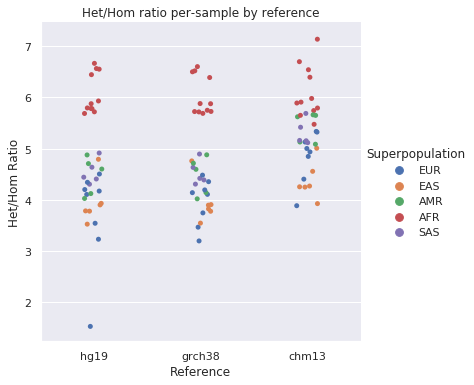

count  mean  std  min  25%  50%  75%   max
reference svtype                                            
chm13     DEL     35.00  3.96 0.49 2.91 3.76 3.98 4.23  5.13
          INS     35.00  7.51 1.38 4.81 6.72 7.52 8.24 10.67
          TOT     35.00  5.32 0.76 3.89 4.97 5.32 5.72  7.14
grch38    DEL     35.00  3.11 0.56 2.24 2.75 2.94 3.73  4.08
          INS     35.00  6.54 1.61 3.90 5.33 6.15 7.91  9.70
          TOT     35.00  4.77 0.97 3.20 4.07 4.48 5.72  6.60
hg19      DEL     35.00  3.08 0.65 1.15 2.75 2.94 3.75  4.10
          INS     35.00  6.49 1.81 1.81 5.31 6.17 7.88  9.87
          TOT     35.00  4.72 1.12 1.53 4.07 4.51 5.75  6.67

In [6]:
exact_data = data[(data["merge"] == "exact")]

display(Markdown("# Exact Merging - Per-Sample Stats"))
display(Markdown("## SVCounts per-sample"))
exact_sv_counts = plot_sv_counts(exact_data)
display(Markdown("## SVCounts by SZBIN per-sample"))
exact_sz_counts = plot_svsize_counts(exact_data)
display(Markdown("## SV HET/HOM Ratios"))
exact_gt_counts = plot_hethom_stats(exact_data)

# Loose Merging - Per-Sample Stats

## SVCounts per-sample

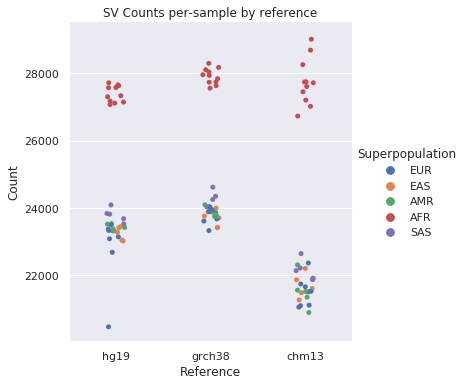

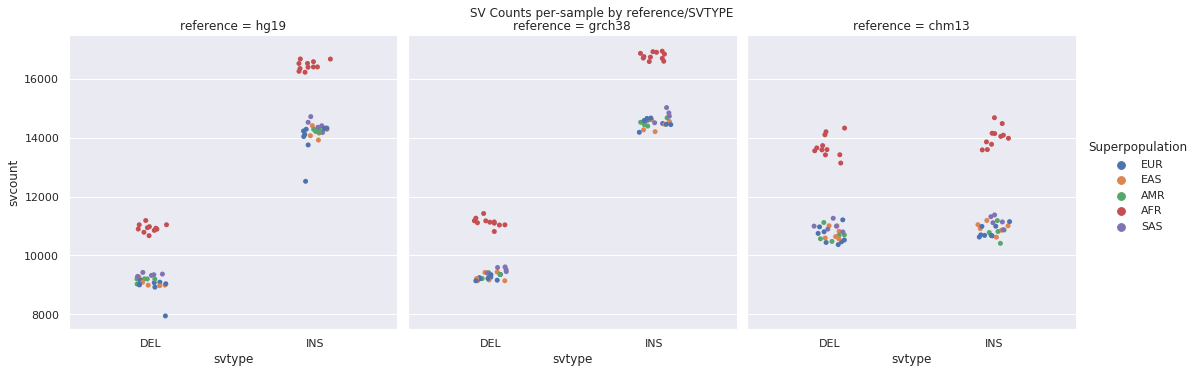

svcount                                                
            count   mean   std    min    25%    50%    75%    max
reference                                                        
chm13          35 23,592 2,900 20,882 21,510 21,906 27,111 29,015
grch38         35 25,135 1,927 23,321 23,751 24,011 27,684 28,298
hg19           35 24,566 2,020 20,458 23,321 23,512 27,128 27,718

svcount                                                
                   count   mean   std    min    25%    50%    75%    max
reference svtype                                                        
chm13     DEL         35 11,697 1,410 10,366 10,662 10,993 13,422 14,331
          INS         35 11,896 1,496 10,408 10,833 11,110 13,689 14,684
grch38    DEL         35  9,884   865  9,134  9,228  9,409 11,034 11,424
          INS         35 15,250 1,068 14,187 14,499 14,614 16,654 16,947
hg19      DEL         35  9,672   897  7,938  9,052  9,245 10,818 11,186
          INS         35 14,895 1,130 12,520 14,201 14,329 16,310 16,683

## SVCounts by SZBIN per-sample

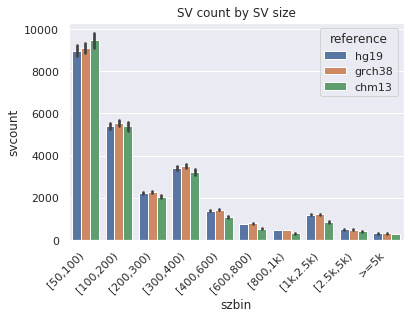

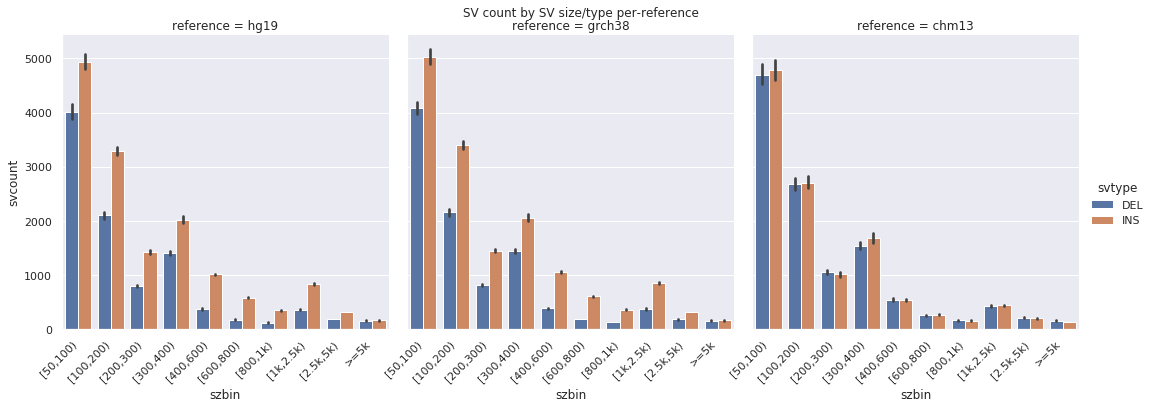

svcount                                            
                      count  mean   std   min   25%   50%    75%    max
reference szbin                                                        
chm13     [50,100)       35 9,472 1,138 8,344 8,668 8,842 10,886 11,509
          [100,200)      35 5,388   673 4,775 4,901 5,002  6,196  6,580
          [200,300)      35 2,055   239 1,816 1,888 1,935  2,299  2,591
          [300,400)      35 3,221   455 2,794 2,879 2,976  3,744  4,208
          [400,600)      35 1,081   122   926   988 1,025  1,210  1,323
          [600,800)      35   520    71   428   473   497    573    699
          [800,1k)       35   313    40   253   284   301    344    411
          [1k,2.5k)      35   859   110   723   778   806    984  1,060
          [2.5k,5k)      35   403    51   334   364   385    454    493
          >=5k           35   278    38   230   252   265    315    343
grch38    [50,100)       35 9,110   780 8,364 8,572 8,669 10,150 10,414
          [100,200)      35 5,553   424 5,115 5,242 5,330  6,115  6,246
          [200,300)      35 2,260   161 2,022 2,150 2,187  2,430  2,551
          [300,400)      35 3,490   306 3,198 3,265 3,316  3,878  4,021
          [400,600)      35 1,432    75 1,325 1,380 1,407  1,510  1,578
          [600,800)      35   790    51   692   758   772    822    888
          [800,1k)       35   477    31   433   455   475    496    546
          [1k,2.5k)      35 1,216    78 1,119 1,158 1,193  1,299  1,373
          [2.5k,5k)      35   494    41   431   465   482    522    584
          >=5k           35   313    25   266   296   310    329    358
hg19      [50,100)       35 8,957   815 7,319 8,438 8,557 10,015 10,267
          [100,200)      35 5,384   437 4,507 5,106 5,167  5,940  6,090
          [200,300)      35 2,216   172 1,882 2,105 2,153  2,400  2,497
          [300,400)      35 3,419   314 2,842 3,194 3,269  3,832  3,957
          [400,600)      35 1,378    84 1,177 1,334 1,363  1,456  1,553
          [600,800)      35   749    50   671   712   733    788    849
          [800,1k)       35   462    30   404   440   459    483    521
          [1k,2.5k)      35 1,189    86 1,013 1,122 1,164  1,270  1,353
          [2.5k,5k)      35   498    43   407   472   489    526    585
          >=5k           35   313    28   235   298   307    332    356

svcount                                        
                             count  mean std   min   25%   50%   75%   max
reference svtype szbin                                                    
chm13     DEL    [50,100)       35 4,694 560 4,141 4,292 4,415 5,384 5,680
                 [100,200)      35 2,682 337 2,310 2,443 2,519 3,102 3,281
                 [200,300)      35 1,046 117   914   957   984 1,162 1,283
                 [300,400)      35 1,536 182 1,347 1,402 1,446 1,726 1,943
                 [400,600)      35   540  67   466   490   518   594   694
                 [600,800)      35   255  36   192   234   248   282   339
                 [800,1k)       35   159  20   129   145   152   172   208
                 [1k,2.5k)      35   424  64   350   380   396   495   557
                 [2.5k,5k)      35   208  29   179   186   195   237   265
                 >=5k           35   152  21   118   138   144   174   191
          INS    [50,100)       35 4,778 581 4,203 4,354 4,490 5,522 5,831
                 [100,200)      35 2,706 338 2,368 2,463 2,523 3,116 3,299
                 [200,300)      35 1,009 126   850   913   963 1,136 1,308
                 [300,400)      35 1,685 274 1,447 1,484 1,529 2,006 2,265
                 [400,600)      35   541  62   436   495   522   589   662
                 [600,800)      35   266  39   206   240   253   291   360
                 [800,1k)       35   155  22   122   136   153   174   203
                 [1k,2.5k)      35   435  49   360   401   417   482   530
                 [2.5k,5k)      35   195  25   152   172   192   215   246
                 >=5k           35   127  19    99   112   120   144   158
grch38    DEL    [50,100)       35 4,080 364 3,689 3,825 3,900 4,548 4,708
                 [100,200)      35 2,157 196 1,932 2,020 2,050 2,400 2,504
                 [200,300)      35   815  69   726   764   785   876   954
                 [300,400)      35 1,438 110 1,309 1,352 1,389 1,574 1,630
                 [400,600)      35   383  38   333   354   368   418   465
                 [600,800)      35   184  22   150   166   179   204   224
                 [800,1k)       35   124  10   108   116   120   130   145
                 [1k,2.5k)      35   369  43   321   333   357   414   456
                 [2.5k,5k)      35   181  24   149   163   171   198   237
                 >=5k           35   155  14   134   144   153   162   187
          INS    [50,100)       35 5,030 420 4,628 4,734 4,777 5,583 5,779
                 [100,200)      35 3,396 232 3,145 3,222 3,280 3,678 3,787
                 [200,300)      35 1,445  95 1,271 1,383 1,406 1,547 1,620
                 [300,400)      35 2,052 198 1,849 1,912 1,956 2,299 2,408
                 [400,600)      35 1,048  45   985 1,019 1,038 1,078 1,154
                 [600,800)      35   606  33   534   586   603   620   673
                 [800,1k)       35   353  23   313   338   350   370   401
                 [1k,2.5k)      35   848  39   794   820   840   869   942
                 [2.5k,5k)      35   313  20   272   299   310   327   364
                 >=5k           35   158  14   132   148   157   165   183
hg19      DEL    [50,100)       35 4,018 378 3,310 3,781 3,838 4,482 4,657
                 [100,200)      35 2,100 200 1,708 1,972 2,000 2,338 2,451
                 [200,300)      35   795  73   670   742   766   868   926
                 [300,400)      35 1,403 112 1,182 1,320 1,358 1,550 1,585
                 [400,600)      35   371  38   307   342   358   404   458
                 [600,800)      35   173  24   143   156   165   194   223
                 [800,1k)       35   117  11    96   110   117   124   141
                 [1k,2.5k)      35   358  47   272   325   344   406   444
                 [2.5k,5k)      35   183  24   138   166   175   204   235
                 >=5k           35   152  16   112   142   152   162   186
          INS    [50,100)       35 4,940 441 4,009 4

## SV HET/HOM Ratios

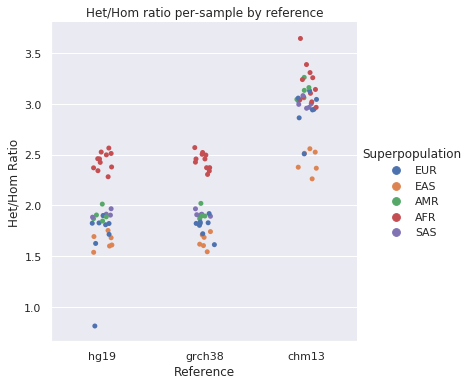

count  mean  std  min  25%  50%  75%  max
reference svtype                                           
chm13     DEL     35.00  2.78 0.28 2.11 2.74 2.84 2.96 3.33
          INS     35.00  3.18 0.35 2.43 3.11 3.25 3.31 3.99
          TOT     35.00  2.97 0.31 2.26 2.94 3.04 3.13 3.64
grch38    DEL     35.00  2.27 0.35 1.68 2.10 2.18 2.62 2.85
          INS     35.00  1.86 0.30 1.46 1.66 1.74 2.17 2.41
          TOT     35.00  2.01 0.32 1.54 1.81 1.90 2.35 2.57
hg19      DEL     35.00  2.24 0.41 0.94 2.06 2.18 2.63 2.87
          INS     35.00  1.82 0.36 0.74 1.65 1.74 2.18 2.40
          TOT     35.00  1.97 0.38 0.81 1.78 1.90 2.36 2.56

In [7]:
loose_data = data[(data["merge"] == "loose")]

display(Markdown("# Loose Merging - Per-Sample Stats"))
display(Markdown("## SVCounts per-sample"))
loose_sv_counts = plot_sv_counts(loose_data)
display(Markdown("## SVCounts by SZBIN per-sample"))
loose_sz_counts = plot_svsize_counts(loose_data)
display(Markdown("## SV HET/HOM Ratios"))
loose_gt_counts = plot_hethom_stats(loose_data)

# Summary figures
Need to take the views and put them together to make a facetgrid so that 
I can show merging strategy's effects for Counts and Het/Hom ratios

In [8]:
exact_sv_counts[0]["merge"] = "exact"
strict_sv_counts[0]["merge"] = "strict"
loose_sv_counts[0]["merge"] = "loose"
sv_counts = pd.concat([exact_sv_counts[0], strict_sv_counts[0], loose_sv_counts[0]])

exact_sv_counts[1]["merge"] = "exact"
strict_sv_counts[1]["merge"] = "strict"
loose_sv_counts[1]["merge"] = "loose"
sv_counts_byty = pd.concat([exact_sv_counts[1], strict_sv_counts[1], loose_sv_counts[1]])

In [9]:
def merge_strategy_plots(m_data, m_data_byty, reference="grch38"):
    is_ref = m_data["reference"] == reference
    ax = sb.violinplot(data=m_data[is_ref], x="merge", y="svcount", color='gray')
    plt.setp(ax.collections, alpha=.3)
    p = sb.swarmplot(data=m_data[is_ref], x="merge", y="svcount", hue="Superpopulation")
    hide = p.set(title=f"Per-Sample SVCounts by Merge Strategy ({reference})", ylim=(19000, 35000))
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title="Superpopulation")
    plt.show()
    p = sb.violinplot(data=m_data_byty[m_data_byty["reference"] == reference], x="merge", y="svcount", hue="svtype")
    hide = p.set(title=f"Per-Sample SVCounts by Merge Strategy ({reference})", ylim=(7000, 22000))
    plt.show()
    

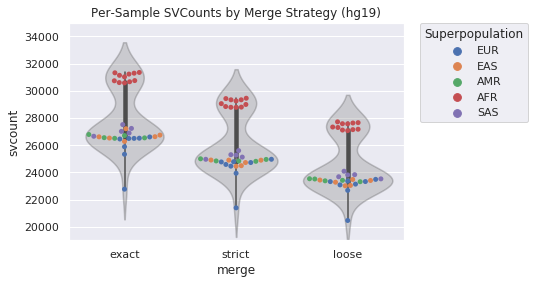

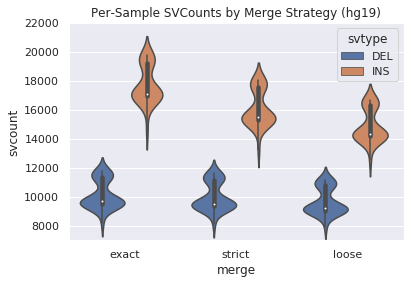

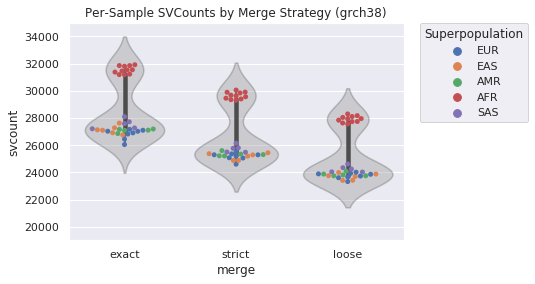

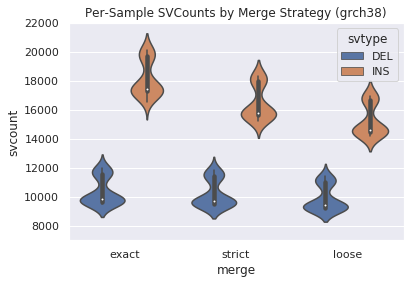

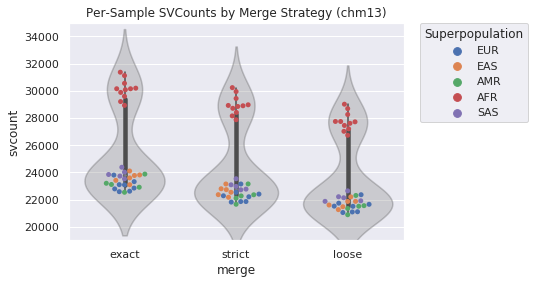

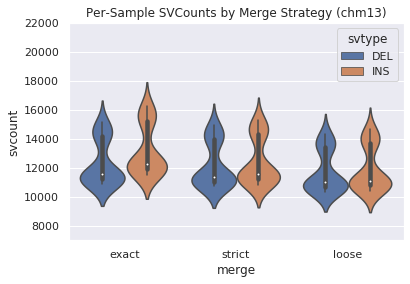

In [10]:
merge_strategy_plots(sv_counts, sv_counts_byty, "hg19")
merge_strategy_plots(sv_counts, sv_counts_byty, "grch38")
merge_strategy_plots(sv_counts, sv_counts_byty, "chm13")


# Het/Hom Ratios per-sample

In [28]:
view = []
for name, big_df in [("exact", exact_gt_counts), ("strict", strict_gt_counts), ("loose", loose_gt_counts)]:
    for i, d in big_df.groupby(["reference", "sample", "Superpopulation"]):
        d.set_index("svtype", inplace=True)
        view.append([*i, name, d.loc["DEL"].Ratio, d.loc["INS"].Ratio, d.loc["TOT"].Ratio])
view = pd.DataFrame(view, columns=["reference", "sample", "Superpopulation", "merge", "DEL Ratio", "INS Ratio", "Ratio"])

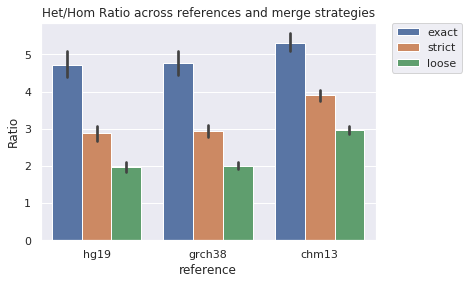

In [38]:
p = sb.barplot(data=view, x="reference", hue="merge", y="Ratio", order=["hg19", "grch38", "chm13"])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
hide = p.set(title="Het/Hom Ratio across references and merge strategies")

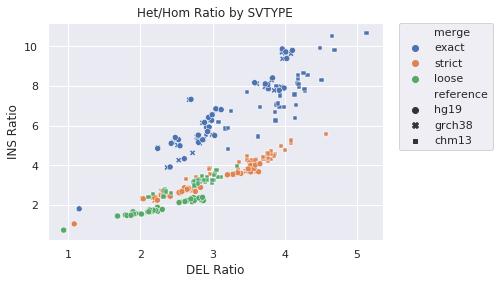

In [39]:
p = sb.scatterplot(data=view, 
                   x="DEL Ratio", 
                   y="INS Ratio", 
                   hue="merge", 
                   style="reference", 
                   markers=True,
                  style_order=["hg19", "grch38", "chm13"])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
hide = p.set(title="Het/Hom Ratio by SVTYPE")

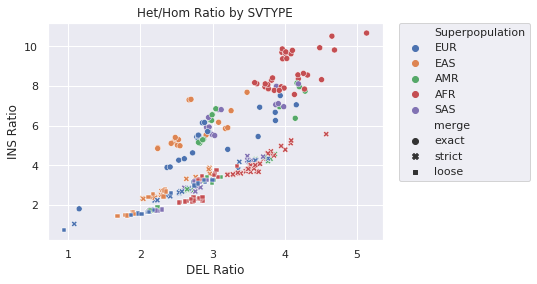

In [41]:
p = sb.scatterplot(data=view, 
                   x="DEL Ratio", 
                   y="INS Ratio", 
                   hue="Superpopulation", 
                   style="merge", 
                   markers=True)
                  #style_order=["hg19", "grch38", "chm13"])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
hide = p.set(title="Het/Hom Ratio by SVTYPE")

In [48]:
view.groupby(["reference", "merge"]).mean().applymap("{0:.2f}".format).T

reference chm13              grch38               hg19             
merge     exact loose strict  exact loose strict exact loose strict
DEL Ratio  3.96  2.78   3.56   3.11  2.27   2.80  3.08  2.24   2.77
INS Ratio  7.51  3.18   4.30   6.54  1.86   3.02  6.49  1.82   2.96
Ratio      5.32  2.97   3.91   4.77  2.01   2.93  4.72  1.97   2.89